<a href="https://colab.research.google.com/github/sharadv99/capstone-OpioidAddictionRisk/blob/master/Opioid_04Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opioid Addiction Project
## Notebook 04: Modeling

This notebook executes the following tasks:

1. Model Preprocessing
2. Train a machine learning model
3. Score the model (measuring accuracy, precision, recall, F1, ROC)
4. Calibrate the model (and re-score, comparing uncalibrated vs. calibrated)
5. Save the model and calibration

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [0]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
import itertools

#Model Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn

#Modeling
import xgboost #conda install py-xgboost

#Model evaluation
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, 
                             classification_report)

#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib.pyplot as plt

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 20
dataDir = './data/'

#Notebook Custom Parameters
useSMOTE = False

print('Pandas Version', pd.__version__)

Pandas Version 0.24.1


# 1. Load Data

This step loads the data from the file `data.pickle.zip`.

In [0]:
#Load Data
df = pd.read_pickle(dataDir+'features.pickle.zip')
df

,IRSEX,IREDUHIGHST2,AGE2,BNGDRKMON,HVYDRKMON,TXYRRECVD2,TXEVRRCVD2,FUMJ18,FUMJ21,MISUSE,...,ADDSCEV_2,ADDSCEV_94,ADDSCEV_97,ADDSCEV_98,ADDSCEV_99,BOOKED_2,BOOKED_85,BOOKED_94,BOOKED_97,BOOKED_98
19,0,-1.407065,-1.188806,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
20,1,-0.658529,-0.730225,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
21,0,0.464275,-0.607937,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
23,0,0.464275,-0.944230,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
33,0,-0.284261,-0.730225,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
34,0,0.464275,-0.883085,1,1,0,0,1,1,1,...,1,0,0,0,0,1,0,0,0,0
36,1,-0.658529,2.174124,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46,1,-0.284261,-0.944230,0,0,0,0,1,1,1,...,1,0,0,0,0,1,0,0,0,0
50,0,0.838544,0.462087,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
52,0,-1.407065,-1.188806,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


# 2. Model Preprocessing

In this section we'll ...

* Split the data into features (X) and the outcome variable, MISUSE (Y).
* Split the data into training, validation, and test sets.
* Oversample the data to address imbalance (optional, depending on modeling needs)

## 2.1 Split Features (X) and Outcome (Y)

In [0]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

#Inspect
print(dfX.head())
print(dfY.head(10))

    ADDPREV_2  ADDPREV_85  ADDPREV_94  ADDPREV_97  ADDPREV_98  ADDPREV_99  \
19          0           0           0           0           0           1   
20          0           0           0           0           0           0   
21          1           0           0           0           0           0   
23          1           0           0           0           0           0   
33          1           0           0           0           0           0   

    ADDSCEV_2  ADDSCEV_94  ADDSCEV_97  ADDSCEV_98  ...  MJYRTOT__GT985LTET991  \
19          0           0           0           0  ...                      1   
20          0           0           0           0  ...                      0   
21          1           0           0           0  ...                      1   
23          1           0           0           0  ...                      1   
33          1           0           0           0  ...                      0   

    MJYRTOT__GT991LTET993  MJYRTOT__GT993LTET994  

## 2.2 Split into Training, Validation, and Test

In [0]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(32014, 119)
(32014, 1)
(13340, 119)
(13340, 1)
(8004, 119)
(8004, 1)


In [0]:
#SMOTE Oversampling
if useSMOTE:
    #From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    os = SMOTE(random_state=0)
    columns = trainX.columns
    osX, osY = os.fit_sample(trainX, trainY)
    osX = pd.DataFrame(data=osX,columns=columns)
    osY = pd.DataFrame(data=osY,columns=['MISUSE'])

    #Check the numbers of our data
    print("length of oversampled data is ",len(osX))
    print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
    print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
    print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
    print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

    #Check Shapes
    print(trainX.shape)
    print(trainY.shape)
    print(osX.shape)
    print(osY.shape)
    print(valX.shape)
    print(valY.shape)
    print(testX.shape)
    print(testY.shape)

    #Finally, set trainX and trainY to be osX and osY 
    #(allows the model to use trainX and trainY regardless of whether oversampling is selected)
    trainX, trainY = osX, osY


# 3. Model Training

In this section we'll train a model.

In [0]:
#Set our XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=20, n_estimators=500)

#Train our XGB Model
modelXGB.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# 4. Model Evaluation (uncalibrated)

Here we'll develop the scoring routines to evaluate the uncalibrated model. We'll re-score in the calibration section to compare the uncalibrated vs. calibrated models.

## 4.1 Simple Counts

We'll begin by calculating simple counts of the model's predictions

In [0]:
#Count predictions. This gives a rough idea of the number of predictions
def predCounts(predsIn):
    '''Simple function to count our predictions
    NOTES:
    Return format: [[prediction1, count of prediction1]
                    [prediction2, count of prediction2]]

    The .T at the end simply transposes the array.

    What's nice about this function is it will also detect any counts
    that aren't 0 or 1, which can occasionally happen.
    '''
    return np.asarray(np.unique(predsIn, return_counts=True)).T

preds = modelXGB.predict(valX)
predCountFreq = predCounts(preds)
#print(predCountFreq) #Commenting out here because it's printed below

## 4.2 Accuracy

In [0]:
#Simple accuracy metrics
predProbs = modelXGB.predict_proba(valX)[:, 1]
aucScore = roc_auc_score(y_true=valY, y_score=predProbs)

#Commenting out here because it's printed below
# print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=valY, y_pred=preds, normalize=True)))
# print('Model ROC AUC:  {:.2%}'.format(aucScore))

## 4.3 Confusion Matrix

In [0]:
#Helper Functions for Summarizing and Plotting Results
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Documented here as it is in the source.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix") #Commenting out since we plot this in a graph
    else:
        pass
        #print('Confusion Matrix') #Commenting out since we plot this in a graph

    #print(cm) #Commenting out since we plot this in a graph

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

In [0]:
#Create text classification report
#print(classification_report(valY, preds)) #Commenting out here because it's printed below

# Compute confusion matrix
cnf_matrix = confusion_matrix(valY, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0, 1]

#Commenting out here because it's printed below
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion Matrix')
# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized Confusion Matrix')

# plt.show()

## 4.4 ROC Curve

In [0]:
#Function to plot ROC Curve
def pltROCCurve(fprIn, tprIn):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fprIn, tprIn, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_true=valY, y_score=predProbs))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate\n(how often predicts misuse when no misuse)')
    plt.ylabel('True Positive Rate\n(how often predicts misuse when actual misuse)')
    plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(valY, predProbs)
#Commenting out here because it's printed below
#pltROCCurve(fpr, tpr)

## 4.5 Calibraiton Curve

In [0]:
#Function to plot calibration curve
def pltCalCurve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, n_bins=20, normalize=True)

    #Plot diag line
    plt.plot([0, 1], [0, 1], linestyle='--')

    #Plot calibration curves
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Actual Probabilities')
    plt.show()

In [0]:
#Plot CalCurve
#pltCalCurve(valY, predProbs) #Commenting out here because it's printed below

## 4.6 Metrics Summary

This is just a convenient place to put all the metrics we've already calculated in one spot.

In [0]:
def resultsSummary(preds, predProbs):
    #Calculate Inputs
    cnf_matrix = confusion_matrix(valY, preds)

    #Counts
    print('PREDICTION COUNTS:\n', predCounts(preds))

    #Accuracy
    print('\nACCURACY SCORES:')
    print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=valY, y_pred=preds, normalize=True)))
    print('Model ROC AUC:  {:.2%}'.format(roc_auc_score(y_true=valY, y_score=predProbs)))

    #Distribution of Predictions
    print('\nDISTRIBUTION OF PREDICTIONS:')
    plt.hist(predProbs, bins=20)
    plt.show()

    #Classificaiton Report
    print('\nCLASSIFICATION REPORT:')
    print(classification_report(valY, preds))

    #Plot Confusion Matrix
    print('CONFUSION MATRIX:')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    #Print ROC Curve
    fpr, tpr, thresholds = roc_curve(valY, predProbs)
    print('ROC CURVE:')
    pltROCCurve(fpr, tpr)
    
    #Plot CalCurve
    pltCalCurve(valY, predProbs)

PREDICTION COUNTS:
 [[    0 12248]
 [    1  1092]]

ACCURACY SCORES:
Model Accuracy: 83.19%
Model ROC AUC:  70.11%

DISTRIBUTION OF PREDICTIONS:


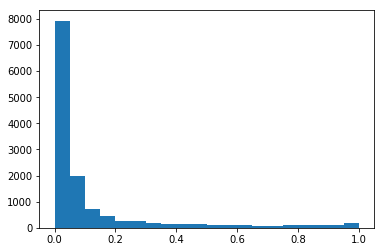


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11168
           1       0.47      0.24      0.31      2172

   micro avg       0.83      0.83      0.83     13340
   macro avg       0.67      0.59      0.61     13340
weighted avg       0.80      0.83      0.81     13340

CONFUSION MATRIX:


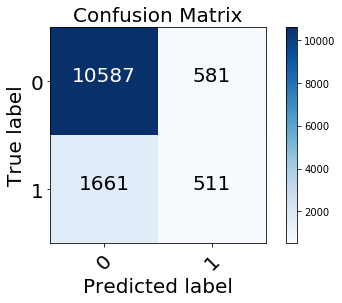

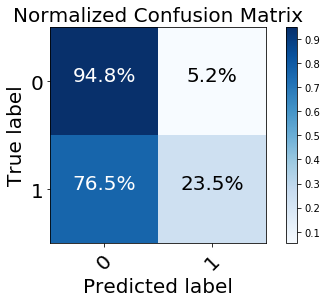

ROC CURVE:


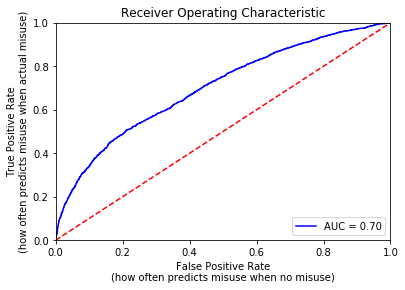

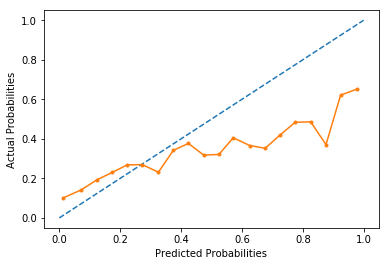

In [0]:
preds = modelXGB.predict(valX)
predProbs = modelXGB.predict_proba(valX)[:, 1]
resultsSummary(preds, predProbs)

# 5. Calibration

This section seeks to calibrate the model. That is, it makes the acutal probabilities from the model align with the actual probabilities.

In [0]:
#Now we'll try to calibrate the model
calibrator = CalibratedClassifierCV(modelXGB, cv=3) #cv='prefit' gives an error.
calibrator.fit(valX, valY)

#calProbs = calibrator.predict_proba(valX)[:,1]
#pltCalCurve(valY, calProbs)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
            cv=3, method='sigmoid')

PREDICTION COUNTS:
 [[    0 12823]
 [    1   517]]

ACCURACY SCORES:
Model Accuracy: 87.59%
Model ROC AUC:  99.35%

DISTRIBUTION OF PREDICTIONS:


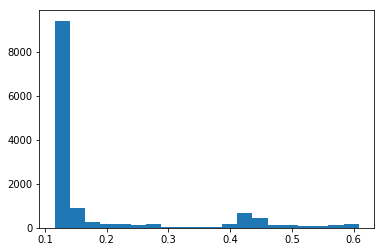


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     11168
           1       1.00      0.24      0.38      2172

   micro avg       0.88      0.88      0.88     13340
   macro avg       0.94      0.62      0.66     13340
weighted avg       0.89      0.88      0.84     13340

CONFUSION MATRIX:


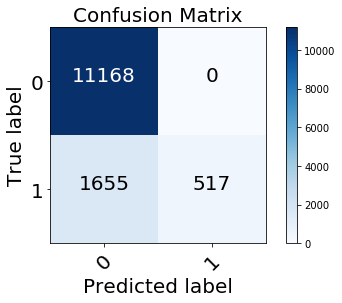

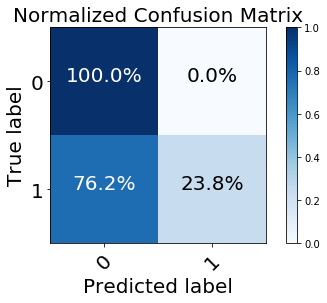

ROC CURVE:


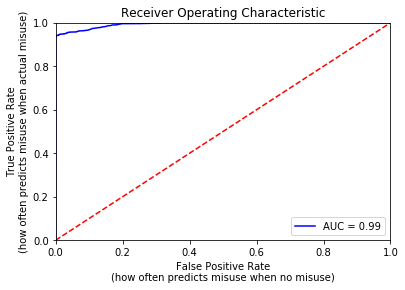

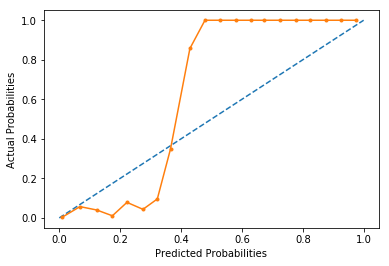

In [0]:
#Now recalculate predictions and print results
preds = calibrator.predict(valX)
predProbs = calibrator.predict_proba(valX)[:,1]
resultsSummary(preds, predProbs)

# 6. Save Model to Disk

Saving the model to disk at this point saves time, specifically so we don't have to re-train it every time we want to use it for predictions, feature importance, report generation, etc.

In [0]:
#Save model and any other necessary files
joblib.dump(modelXGB, dataDir+'modelXGB.model')
joblib.dump(calibrator, dataDir+'calibXGB.model')

#Save data files necessary for calculating feature importance
valX.to_pickle(dataDir+'valX.pickle.zip') #Remember the .zip at the end of the filename tells it to compress
testX.to_pickle(dataDir+'testX.pickle.zip') #Remember the .zip at the end of the filename tells it to compress